In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

In [2]:
df = pd.read_csv('input/Video_Games_Sales_as_at_22_Dec_2016.csv', encoding="utf-8")
dfa = df
dfa = dfa.copy()
df[:5]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Top values in the dataset
---
**By platform, developer, publisher and genre.**

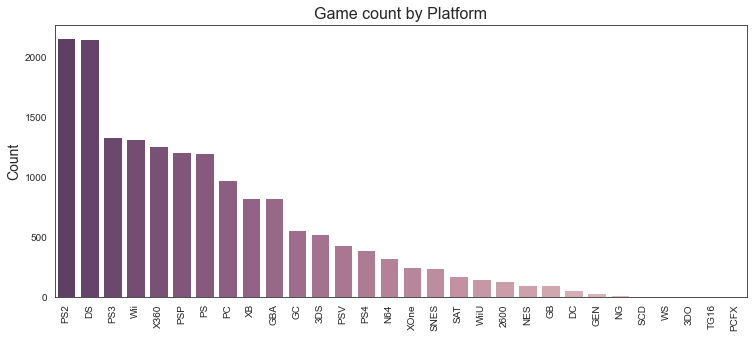

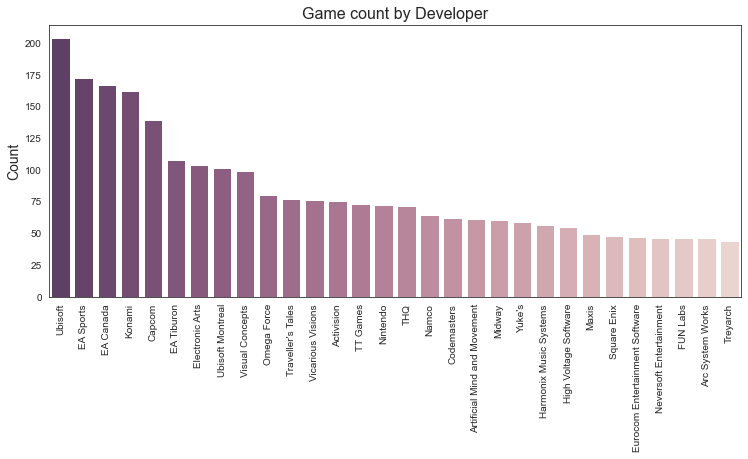

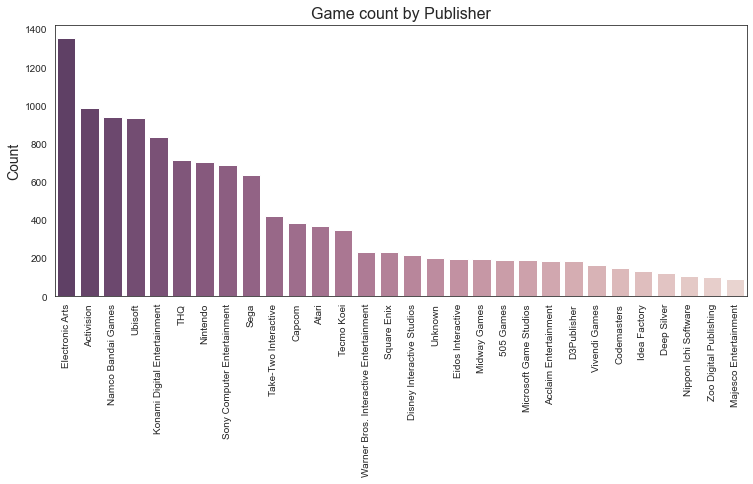

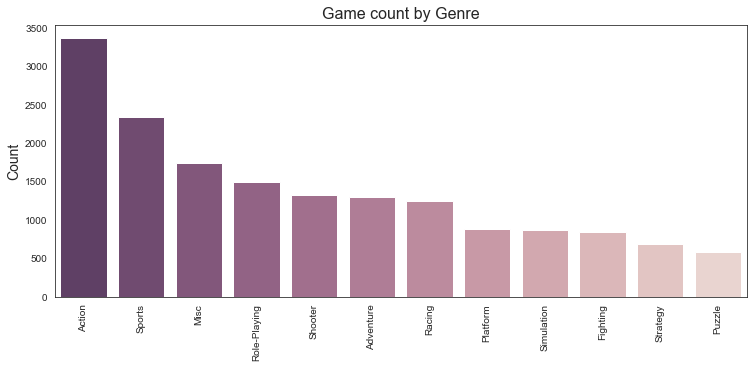

In [3]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

Sales vs. critic scores
--------------------------------
**By platform, developer, publisher, and genre.**

In [4]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [5]:
dfh = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['Critic_Score'].apply(lambda x: score_group(x))

In [6]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Platform':
        return 14.4
    elif x == 'Developer':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

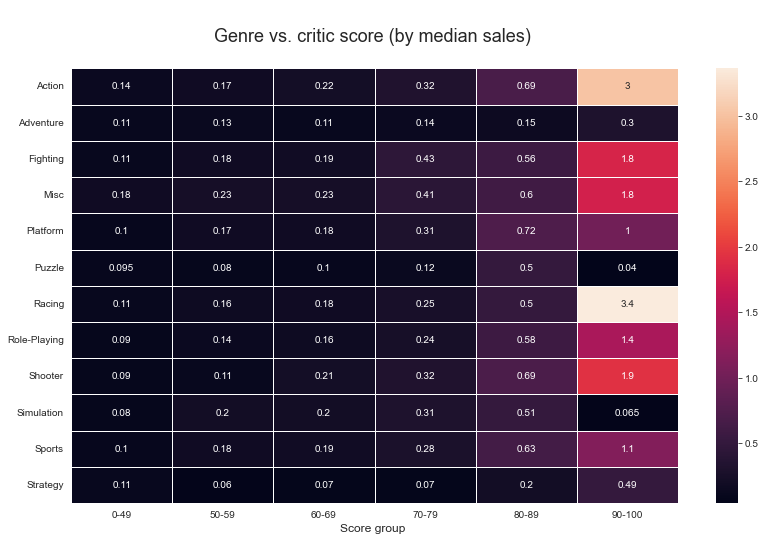

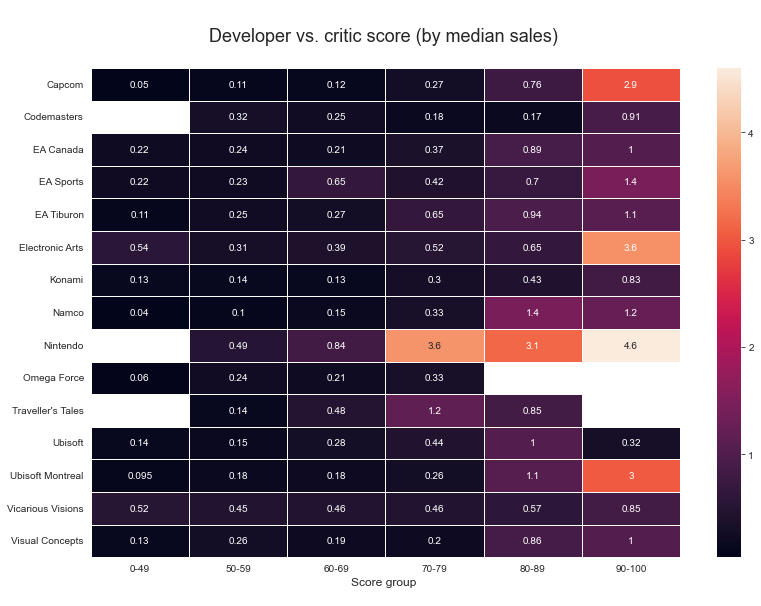

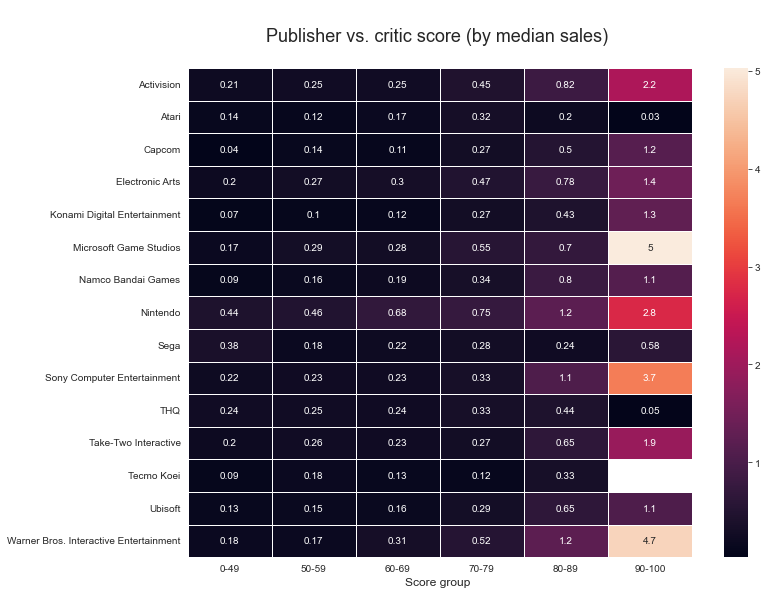

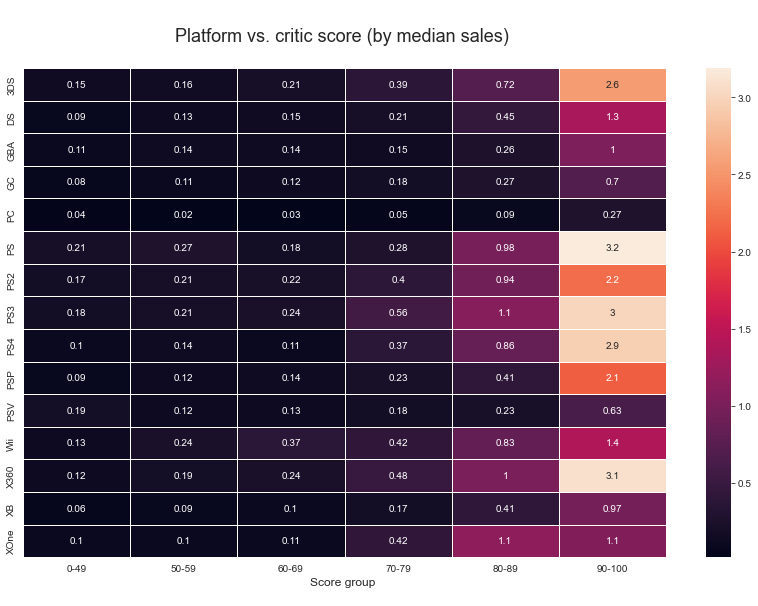

In [7]:
cols = ['Genre', 'Developer', 'Publisher', 'Platform']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

Dataset correlations
--------------------------------
**Conversion of categorical columns into numeric codes**

In [8]:
cols = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [9]:
df1 = df[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

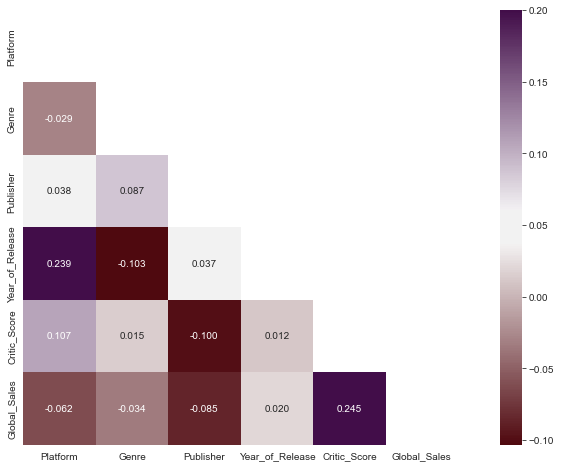

In [10]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

**Strongest correlations are:**

 

 - ***Critic scores-to-global sales*:  We'll take a closer look at this below.**
 
 - ***Year of release-to-platform*:  This makes sense since new platforms come out periodically.**

Critic scores to global sales
-----------------------------

[(0.0, 17.5)]

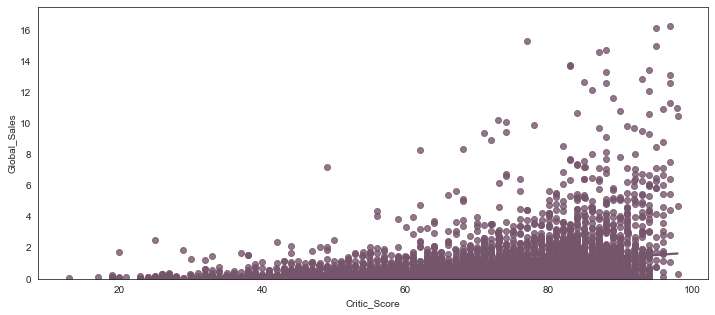

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

**We'll go ahead and use bins to get a better feel for the correlation.**

[(0.0, 4.0), (50.0, 95.0)]

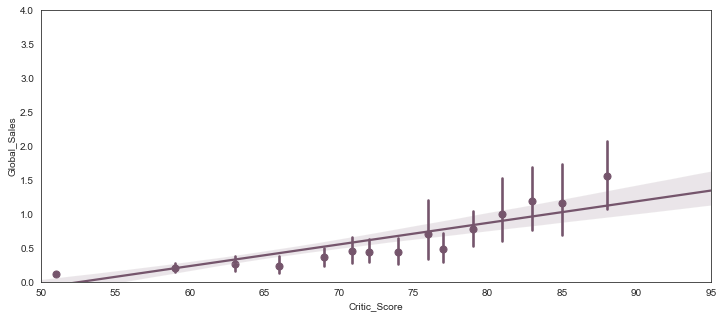

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

**The relationship looks much clearer now. It's interesting how the slope gets steeper in the 80's. It seems once a game gets a high critic score, every additional point has a higher impact. Go big or go home, right?** 

**Looks like critic scores will be a good feature for the prediction model in section 2.**

Defining *hits* as those with sales above 1 million units
---------------------------------------------------------
**This will be the target in our prediction model, where we'll predict if a game will be a hit or not.**

In [13]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [14]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

**Let's graph the relationship between critic scores and VG hits using a 5% sample...** 

<AxesSubplot:xlabel='Critic_Score', ylabel='Hit'>

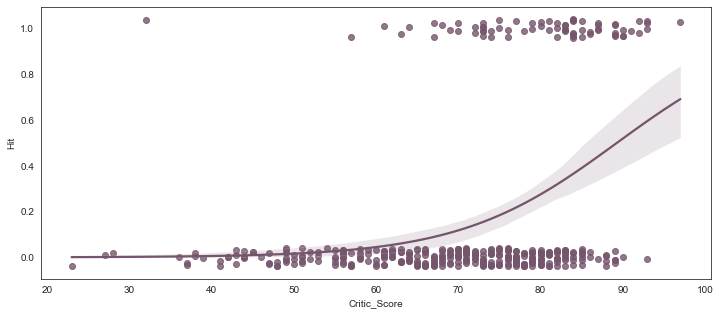

In [15]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

**As expected, it seems hits are mostly found near high critic scores, while non-hits can vary in scores but don't have as strong of a presence in the high score ranges (as seen in the steepening regression curve near the 70's).**

----------

2. Prediction model
=============================
**For predicting VGs with unit sales of 1 million or higher (hits).**

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm

Generating features
------------------------------------------------------------------------

In [17]:
df2[:5]

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


In [18]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)

In [19]:
df_copy[:5]

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
0,2006.0,76.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008.0,82.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2009.0,80.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006.0,89.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006.0,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

Testing prediction accuracy with LR and RFC
-------------------------------------------

In [22]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.864946128789777


In [23]:
log_reg = LogisticRegression().fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.8674517664745678


C:\Users\kingd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3301
           1       0.74      0.36      0.49       690

    accuracy                           0.87      3991
   macro avg       0.81      0.67      0.71      3991
weighted avg       0.85      0.87      0.85      3991



In [25]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3301
           1       0.74      0.36      0.49       690

    accuracy                           0.87      3991
   macro avg       0.81      0.67      0.71      3991
weighted avg       0.85      0.87      0.85      3991



Ranking feature performance
---------------------------

In [26]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking (top 10):')

for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking (top 10):
1. feature 1 Critic_Score (0.326461)
2. feature 0 Year_of_Release (0.166946)
3. feature 216 Publisher_Nintendo (0.027233)
4. feature 19 Genre_Action (0.021519)
5. feature 99 Publisher_Electronic Arts (0.019508)
6. feature 27 Genre_Shooter (0.019204)
7. feature 42 Publisher_Activision (0.017003)
8. feature 29 Genre_Sports (0.016701)
9. feature 9 Platform_PS2 (0.014028)
10. feature 10 Platform_PS3 (0.014002)


----------

3. Which 2016 games can still become hits?
====================================

In [27]:
not_hit_copy = df_copy[df_copy['Hit'] == 0]

In [28]:
df4 = not_hit_copy
y = df4['Hit'].values
df4 = df4.drop(['Hit'],axis=1)
X = df4.values

In [29]:
pred = log_reg.predict_proba(X)

In [30]:
dfb = dfb[dfb['Global_Sales'] < 1]

In [31]:
dfb['Hit_Probability'] = pred[:,1]

In [32]:
dfb = dfb[dfb['Year_of_Release'] == 2016]
dfb.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
dfb = dfb[['Name', 'Platform', 'Hit_Probability']]

Top 10 games from 2016 with *highest* probability of becoming hits:
---------------

In [33]:
dfb[:10].reset_index(drop=True)

,Name,Platform,Hit_Probability
0,Dishonored 2,PS4,0.780031
1,Titanfall 2,PS4,0.758495
2,Dishonored 2,XOne,0.755514
3,Titanfall 2,XOne,0.695417
4,Skylanders Imaginators,PS4,0.653327
5,Quantum Break,XOne,0.610887
6,Plants vs. Zombies: Garden Warfare 2,PS4,0.603333
7,Lego Star Wars: The Force Awakens,PS4,0.596018
8,Kirby: Planet Robobot,3DS,0.595091
9,Skylanders Imaginators,XOne,0.578060


Top 10 games from 2016 with *lowest* probability of becoming hits:
---------------

In [34]:
dfb[:-11:-1].reset_index(drop=True)

,Name,Platform,Hit_Probability
0,Psycho-Pass: Mandatory Happiness,PSV,0.002301
1,Dino Dini's Kick Off Revival,PS4,0.002906
2,RollerCoaster Tycoon World,PC,0.003494
3,Bus Simulator 16,PC,0.003883
4,Battle Worlds: Kronos,PC,0.004052
5,Dead or Alive Xtreme 3: Fortune,PS4,0.004204
6,The Technomancer,PC,0.004938
7,Sherlock Holmes: The Devil's Daughter,PC,0.005185
8,Agatha Christie: The ABC Murders,PC,0.005510
9,Homefront: The Revolution,PC,0.005786
